In [1]:
import os
import time
import random
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch
import pybullet as p
import pybullet_data

import roboticstoolbox as rtb
from core.sim.physics_utils import (
    PyBulletSim, load_object_urdf, load_table_urdf, get_object_extents
)
from core.sim.camera_manager import CameraManager
from core.sim.robot_manager import RobotController

def random_pos(x_range, y_range, z_range):
	return [
		random.uniform(*x_range),
		random.uniform(*y_range),
		random.uniform(*z_range)
	]

OBJS_DIR = os.path.join('core', 'sim', 'objects')

# Simulation

Loading random rearrangement: rearrangement_00261
Loading specific rearrangement: rearrangement_00261
Scene ID: 261
Number of objects: 5
Grid size: [100, 100]
Loading specific rearrangement: rearrangement_00261


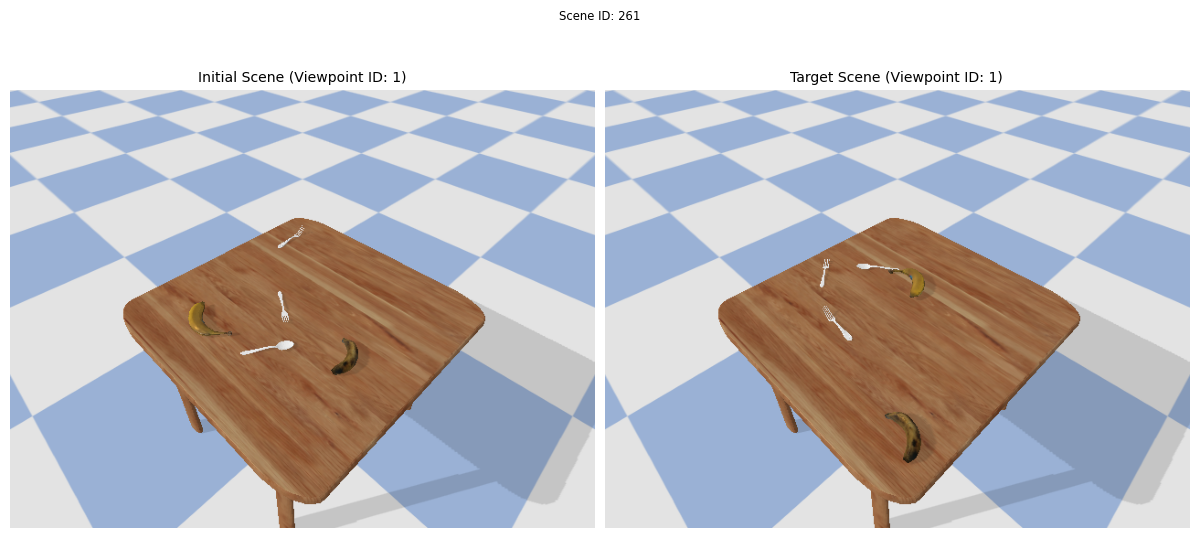

Using default object sizes
Manipulator at [49, 49]


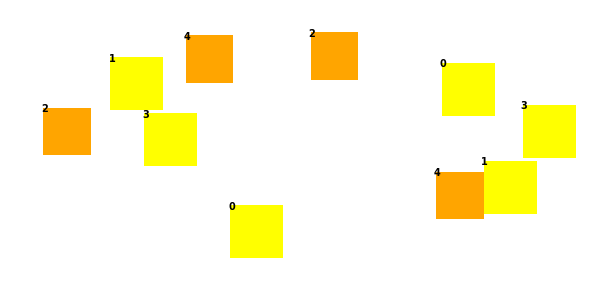

--------Labbe_S--------
plan: [21630, 34407, 46675, 7032, 16393, 2878]
elapsed_time: 0.065s
steps: 23
Moved 2 to: [16 10] | cost: 0.784 | done: False
Moved 3 to: [43 87] | cost: 1.059 | done: False
Moved 4 to: [66 55] | cost: 1.021 | done: False
Moved 0 to: [70 12] | cost: 1.320 | done: False
Moved 1 to: [63 73] | cost: 1.214 | done: False
Moved 0 to: [28 58] | cost: 1.665 | done: True
episode cost: 7.063
Buffer of obj 0 changed from pos [70, 12] to pos [44, 64]
cost got better from 7.063 to 5.578


In [4]:
from core.env.scene_manager import SceneManager
from core.env.scene_utils import scene_meta_to_x
from core.planners.planning_utils import evaluate_alg
from core.planners.plan_optimizer import plan_refinement
from core.planners.Labbe import Labbe_S
from core.sim.rearrangemet_loader import select_rearrangement_dir, load_rearrangement_meta, visualize_rearrangement

scene_id = None
dataset_dir = 'dataset-sim'
folder_path, scene_id = select_rearrangement_dir(dataset_dir, scene_id=scene_id)
meta_data = load_rearrangement_meta(dataset_dir, scene_id=scene_id)

print(f"Scene ID: {meta_data.get('scene_id', 'Unknown')}")
print(f"Number of objects: {meta_data.get('num_objects', 'Unknown')}")
print(f"Grid size: {meta_data.get('grid_size', 'Unknown')}")

visualize_rearrangement(dataset_dir, scene_id=scene_id)
initial_x, target_x = scene_meta_to_x(meta_data)
env = SceneManager(
    num_objects=meta_data['num_objects'],
    grid_size=tuple(meta_data['grid_size'])
)
env.reset(initial_scene=initial_x, target_scene=target_x)
env.render(fig_size=3)

plan1 = evaluate_alg(env, Labbe_S, initial_x, target_x)
plan1, _, _ = plan_refinement(env, plan1, initial_x, target_x, refine_mode="stack", verbose=1)

Loaded 5 objects with complete initial and target information
Moved 2 to: [16 10] | cost: 0.784 | done: False
moving 2 to -0.34, -0.40, 0.79
Moved 3 to: [43 87] | cost: 1.059 | done: False
moving 3 to -0.07, 0.37, 0.77
Moved 4 to: [66 55] | cost: 1.021 | done: False
moving 4 to 0.16, 0.05, 0.79
Moved 0 to: [44 64] | cost: 0.979 | done: False
moving 0 to -0.06, 0.14, 0.78
Moved 1 to: [63 73] | cost: 0.926 | done: False
moving 1 to 0.13, 0.23, 0.78
Moved 0 to: [28 58] | cost: 0.810 | done: True
moving 0 to -0.22, 0.08, 0.78


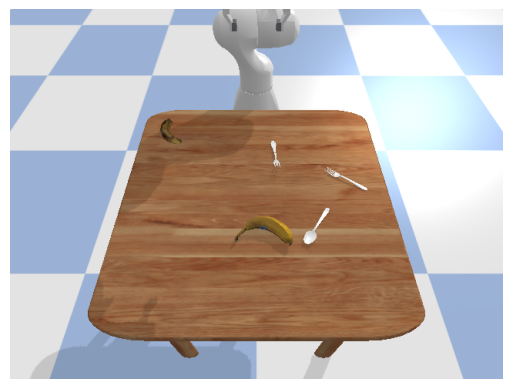

In [6]:
from core.sim.rearrangemet_loader import load_scene_objects_from_labels, grid_to_world_coords

sim = PyBulletSim(p.GUI)
# sim = PyBulletSim(p.DIRECT)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint([0, 0, z], 8)
robot = RobotController("franka_panda/panda.urdf", rtb.models.Panda(), 
              scale=1.5, initial_base_pos=[-0.7, 0, z-0.2], mode='stationary')
init_pos = robot.get_ee_pos()[0]
robot.arm_speed = 0.2
objects = load_scene_objects_from_labels(OBJS_DIR, folder_path)

env.reset(initial_x, target_x)
# env.render(show_manipulator=True, fig_size=3)
# cam.show_img(cam.capture_image())

approach_height = 0.4
grasp_height = 0.2
place_height = 0.2

for action in plan1:
	action_type, obj_idx1, obj_idx2, grid_pos = env.decode_action(action)
	env._step(action_type, obj_idx1, obj_idx2, grid_pos, log=True)
	# env.render(show_manipulator=True, fig_size=3)
	# if objects[obj_idx1]['object_id'] in [0, 1, 2]:
	# 	continue

	body_id_1 = objects[obj_idx1]['body_id']
	body_id_2 = objects[obj_idx2]['body_id']
	obj_pos_1 = p.getBasePositionAndOrientation(body_id_1)[0]
	obj_pos_2 = p.getBasePositionAndOrientation(body_id_2)[0]

	if action_type == 'move':
		# Pick
		robot.pick_object(body_id_1, approach_height=approach_height, grasp_height=grasp_height)
		# Place
		target_pos = grid_to_world_coords(grid_pos.tolist(), world_x_range=[-0.5, 0.5], world_y_range=[-0.5, 0.5])
		target_pos = [target_pos[0], target_pos[1], obj_pos_1[2]]
		robot.place_object(target_pos, approach_height=approach_height, place_height=place_height)
		print(f"moving {obj_idx1} to {target_pos[0]:.2f}, {target_pos[1]:.2f}, {target_pos[2]:.2f}")
		# cam.show_img(cam.capture_image())
	elif action_type == 'stack':
		# Pick
		robot.pick_object(body_id_1, approach_height=approach_height, grasp_height=grasp_height)
		# Place
		target_pos = [obj_pos_2[0], obj_pos_2[1], obj_pos_2[2]+0.1]
		robot.place_object(target_pos, approach_height=approach_height, place_height=place_height)
		# cam.show_img(cam.capture_image())

robot.move_to_position(init_pos)
cam.show_img(cam.capture_image())

sim.close()

# Calibration

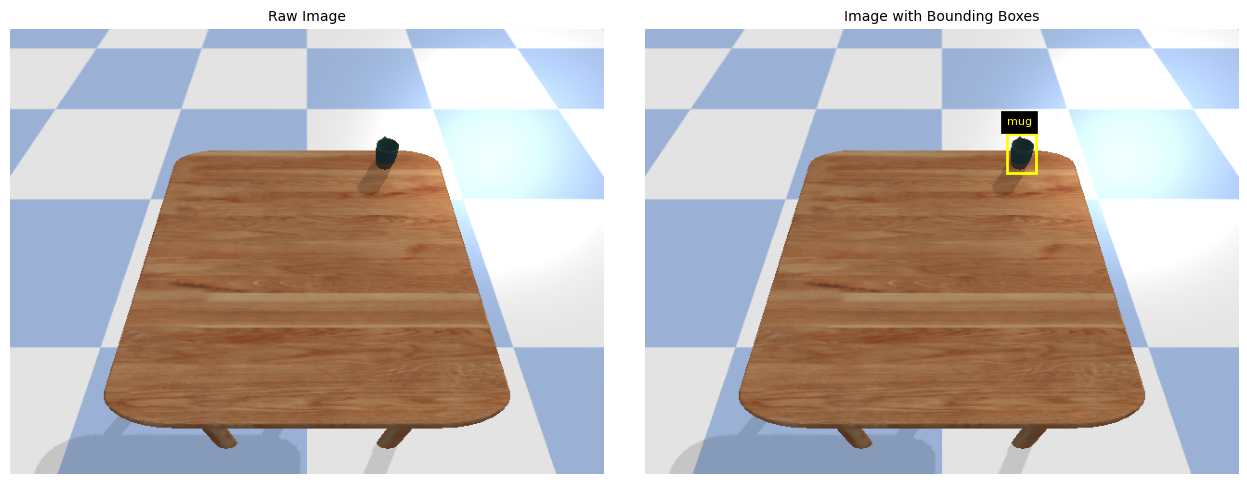


Sum of absolute differences: 0.00000030
Visualizing 3D markers (blue spheres) and 2D markers (red dots)...


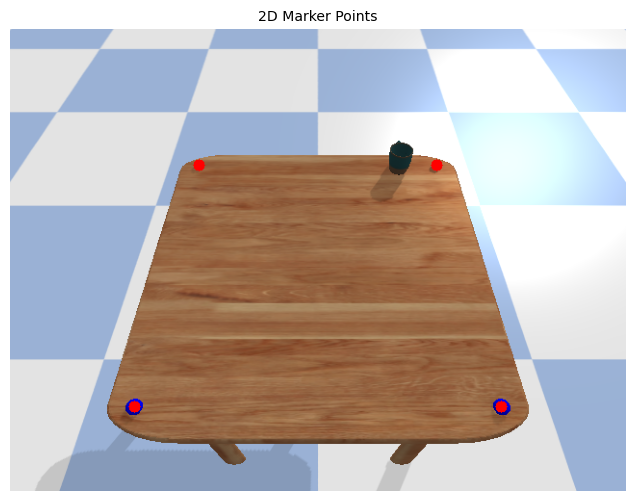

In [ ]:
from core.sim.camera_manager import draw_markers

sim = PyBulletSim(p.GUI)
# sim = PyBulletSim(p.DIRECT)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]
cam = CameraManager()
cam.set_viewpoint([0, 0, z], 8)

mug_id, mug_type = load_object_urdf(OBJS_DIR, 'mug', random_pos([-0.5, 0.5], [-0.5, 0.5], [z+0.05, z+0.05]))
sim.step(1)
bbox = cam.compute_2d_bounding_box(OBJS_DIR, 'mug', mug_id, mug_type)[0]
cam.draw_2d_bounding_boxes(cam.capture_image(), [bbox], ['mug'])
cam.draw_3d_bounding_box(bbox, n=np.array([0, 0, 1]), p0=np.array([0, 0, z+0.05]))

world_pts_test = np.array([
	[0.45, -0.45, z],
	[0.45,  0.45, z],
	[-0.45, 0.45, z],
	[-0.45,-0.45, z]
])
u, v = cam.project_world_to_pixel(world_pts_test)
image_pts_test = np.vstack([u, v]).T
cam.cal_parameters(world_pts_test, image_pts_test)
draw_markers(cam, world_pts_test, image_pts_test)

sim.close()

# Workspace

In [ ]:
import plotly.graph_objects as go

def visualize_workspace_3d_interactive(robot, x_range, y_range, z_heights, table_size, table_z, grid_resolution=6):
    """
    Create an interactive 3D visualization of robot workspace showing TRUE reachability.
    Uses the robot's actual move_end_effector method to physically test each point.
    This is the GROUND TRUTH method for reachability testing.
    """
    
    # Calculate ranges
    x_range_size = x_range[1] - x_range[0]  # 1.0m
    y_range_size = y_range[1] - y_range[0]  # 1.0m  
    z_min, z_max = min(z_heights), max(z_heights)
    z_range_size = z_max - z_min
    
    # Create grids with uniform density (points per meter)
    x_points = np.linspace(x_range[0], x_range[1], grid_resolution)
    y_points = np.linspace(y_range[0], y_range[1], grid_resolution)
    
    # Z-axis gets proportionally fewer points based on its smaller range
    z_resolution = max(2, int(grid_resolution * 1.5 * z_range_size / x_range_size))  # At least 2 points
    z_points = np.linspace(z_min, z_max, z_resolution)
    
    all_reachable_points = []
    all_unreachable_points = []
    
    # Fixed head-down orientation for grasping
    head_down_orientation = [-np.pi, 0, 0]
    
    print(f"X: {len(x_points)} points from {x_range[0]:.3f} to {x_range[1]:.3f}m (range: {x_range_size:.3f}m)")
    print(f"Y: {len(y_points)} points from {y_range[0]:.3f} to {y_range[1]:.3f}m (range: {y_range_size:.3f}m)") 
    print(f"Z: {len(z_points)} points from {z_min:.3f} to {z_max:.3f}m (range: {z_range_size:.3f}m)")
    print(f"Total points to test: {len(x_points) * len(y_points) * len(z_points)}")
    print(f"Point density: ~{grid_resolution/x_range_size:.1f} points/meter")
    print(f"Using orientation: [{head_down_orientation[0]:.3f}, 0, 0]")
    
    # Store initial state to reset after each test
    initial_ee_pos, initial_ee_orn = robot.get_ee_pos()
    
    print(f"Robot initial position: [{initial_ee_pos[0]:.3f}, {initial_ee_pos[1]:.3f}, {initial_ee_pos[2]:.3f}]")
    robot_base_pos, _ = p.getBasePositionAndOrientation(robot.robot_id)
    print(f"Robot base position: [{robot_base_pos[0]:.3f}, {robot_base_pos[1]:.3f}, {robot_base_pos[2]:.3f}]")
    
    # Create list of all points to test for tqdm
    all_test_points = []
    for z_height in z_points:
        for x in x_points:
            for y in y_points:
                all_test_points.append([x, y, z_height])
    
    # Test all points with proper progress bar
    for target_pos in tqdm(all_test_points, desc="Testing reachability"):
        try:
            # Reset robot to initial state before each test
            robot.reset_joints()
            
            # Move to initial position first (to ensure consistent starting point)
            robot.move_end_effector(initial_ee_pos, p.getEulerFromQuaternion(initial_ee_orn))
            
            # Try to move robot to target position using move_end_effector method
            robot.move_end_effector(target_pos, head_down_orientation)
            
            # Check if robot actually reached the target position and orientation
            actual_ee_pos, actual_ee_orn = robot.get_ee_pos()
            actual_ee_euler = p.getEulerFromQuaternion(actual_ee_orn)
            
            # Calculate position error
            pos_error = np.linalg.norm(np.array(actual_ee_pos) - np.array(target_pos))
            
            # Calculate orientation error (handle both pi and -pi representations)
            orn_error = min(
                np.linalg.norm(np.array(actual_ee_euler) - np.array(head_down_orientation)),
                np.linalg.norm(np.array(actual_ee_euler) - np.array([np.pi, 0, 0]))
            )
            
            # Check if both position and orientation are acceptable
            if pos_error < 0.05 and orn_error < 0.2:  # More lenient tolerances
                all_reachable_points.append(target_pos)
                # print(f"✓ REACHABLE: [{target_pos[0]:.3f}, {target_pos[1]:.3f}, {target_pos[2]:.3f}] (pos_err: {pos_error:.3f}m, orn_err: {orn_error:.3f}rad)")
            else:
                all_unreachable_points.append(target_pos)
                # print(f"✗ UNREACHABLE: [{target_pos[0]:.3f}, {target_pos[1]:.3f}, {target_pos[2]:.3f}] (pos_err: {pos_error:.3f}m, orn_err: {orn_error:.3f}rad)")
                
        except Exception as e:
            # Movement failed - point is unreachable
            all_unreachable_points.append(target_pos)
            print(f"✗ FAILED: [{target_pos[0]:.3f}, {target_pos[1]:.3f}, {target_pos[2]:.3f}] - Exception: {str(e)[:50]}...")
            
            # Reset robot after failure
            try:
                robot.reset_joints()
            except:
                pass
    
    # Reset robot to initial state
    robot.reset_joints()
    
    # Convert to numpy arrays
    all_reachable_points = np.array(all_reachable_points) if all_reachable_points else np.empty((0, 3))
    all_unreachable_points = np.array(all_unreachable_points) if all_unreachable_points else np.empty((0, 3))
    
    # Create interactive 3D plot
    fig = go.Figure()
    
    # Add reachable points (green)
    if len(all_reachable_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=all_reachable_points[:, 0],
            y=all_reachable_points[:, 1],
            z=all_reachable_points[:, 2],
            mode='markers',
            marker=dict(size=8, color='green', opacity=0.9),
            name='Reachable Points',
            hovertemplate='<b>REACHABLE</b><br>X: %{x:.3f}m<br>Y: %{y:.3f}m<br>Z: %{z:.3f}m<extra></extra>'
        ))
    
    # Add unreachable points (red, same size)
    if len(all_unreachable_points) > 0:
        fig.add_trace(go.Scatter3d(
            x=all_unreachable_points[:, 0],
            y=all_unreachable_points[:, 1],
            z=all_unreachable_points[:, 2],
            mode='markers',
            marker=dict(size=8, color='red', opacity=0.9),
            name='Unreachable Points',
            hovertemplate='<b>UNREACHABLE</b><br>X: %{x:.3f}m<br>Y: %{y:.3f}m<br>Z: %{z:.3f}m<extra></extra>'
        ))
    
    # Add robot base position
    robot_base_pos, _ = p.getBasePositionAndOrientation(robot.robot_id)
    fig.add_trace(go.Scatter3d(
        x=[robot_base_pos[0]],
        y=[robot_base_pos[1]], 
        z=[robot_base_pos[2]],
        mode='markers',
        marker=dict(size=15, color='blue', symbol='diamond'),
        name='Robot Base',
        hovertemplate=f'<b>Robot Base</b><br>X: {robot_base_pos[0]:.3f}m<br>Y: {robot_base_pos[1]:.3f}m<br>Z: {robot_base_pos[2]:.3f}m<extra></extra>'
    ))
    
    # Add table surface
    table_width, table_height = table_size
    table_x = [-table_width/2, table_width/2, table_width/2, -table_width/2, -table_width/2]
    table_y = [-table_height/2, -table_height/2, table_height/2, table_height/2, -table_height/2]
    table_z_line = [table_z] * 5
    
    fig.add_trace(go.Scatter3d(
        x=table_x, y=table_y, z=table_z_line,
        mode='lines',
        line=dict(color='brown', width=10),
        name='Table Edge'
    ))
    
    # Add table surface mesh
    fig.add_trace(go.Mesh3d(
        x=[-table_width/2, table_width/2, table_width/2, -table_width/2],
        y=[-table_height/2, -table_height/2, table_height/2, table_height/2],
        z=[table_z, table_z, table_z, table_z],
        i=[0, 0], j=[1, 2], k=[2, 3],
        color='brown', opacity=0.3, name='Table Surface'
    ))
    
    # Update layout with uniform aspect ratio
    fig.update_layout(
        title=f'Robot GROUND TRUTH Reachability (move_end_effector Test)<br>Base at [{robot_base_pos[0]:.3f}, {robot_base_pos[1]:.3f}, {robot_base_pos[2]:.3f}] - {len(x_points)}×{len(y_points)}×{len(z_points)} grid',
        scene=dict(
            xaxis_title='X (m)', 
            yaxis_title='Y (m)', 
            zaxis_title='Z (m)',
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5)),
            aspectmode='manual',  # Manual aspect ratio control
            aspectratio=dict(x=1, y=1, z=z_range_size/x_range_size)  # Scale Z relative to X
        ),
        width=900, height=700
    )
    
    fig.show()
    
    # Print detailed statistics
    total_points = len(all_reachable_points) + len(all_unreachable_points)
    if total_points > 0:
        reachability = len(all_reachable_points) / total_points * 100
        print(f"\nGROUND TRUTH Reachability Results (move_end_effector Test):")
        print(f"Total sampled points: {total_points}")
        print(f"Reachable points: {len(all_reachable_points)}")
        print(f"Unreachable points: {len(all_unreachable_points)}")
        print(f"Overall reachability: {reachability:.1f}%")
        
        if len(all_reachable_points) > 0:
            # Distance analysis
            robot_base_pos_2d = [-0.6, 0]
            distances = np.linalg.norm(all_reachable_points[:, :2] - robot_base_pos_2d, axis=1)
            print(f"Maximum reach: {np.max(distances):.3f}m")
            print(f"Mean reach: {np.mean(distances):.3f}m")
            print(f"Minimum reach: {np.min(distances):.3f}m")
    
    return all_reachable_points, all_unreachable_points

sim = PyBulletSim(p.DIRECT)
table = load_table_urdf(OBJS_DIR, (100, 100))
z = get_object_extents(table)[2]

# Test table area (points above the table)
x_range, y_range = [-0.5, 0.5], [-0.5, 0.5]

# Create robot in stationary mode with CORRECT initialization
robot = RobotController("franka_panda/panda.urdf", rtb.models.Panda(), 
                       scale=1.5, initial_base_pos=[-0.7, 0, z], mode='stationary')

# Test 20cm above table surface (as requested)
z_heights = [z+0.01, z+0.41]
table_size = (1.0, 1.0)

# Grid resolution - Z will automatically get fewer points due to smaller range
print("Testing GROUND TRUTH reachability using move_end_effector method...")
reachable_points, unreachable_points = visualize_workspace_3d_interactive(
    robot, x_range, y_range, z_heights, table_size, z, grid_resolution=10
)

sim.close()